# Generate Friction Surface

The friction surface is foundational to raster-based measurement of travel time and accessibility. For most studies of travel time, we recommend using existing friction surfaces, such as the [Global Friction Surface](https://developers.google.com/earth-engine/datasets/catalog/Oxford_MAP_friction_surface_2019) from the Malaria Atlas Project.

However, we often need customized friction surfaces, this could be because of
1. Resolution of the input raster surfaces  
2. Updated baseline datasets (landcover or road network)  
3. Integrate modifications to travel time, such as disruptions  

This notebook will run through a simple process to calcuate a new travel surface using a baseline landcover dataset and a road network.

In [1]:
import sys, os
import rasterio
import overturemaps

import geopandas as gpd

import GOSTrocks.rasterMisc as rMisc
import GOSTrocks.mapMisc as mapMisc

sys.path.append("../../src")
import GOSTnetsraster.market_access as ma
import GOSTnetsraster.conversion_tables as speed_tables

%load_ext autoreload
%autoreload 2

In [2]:
# define input data
base_folder = 'tutorial_data'
iso3 = 'SEN'
aoi_file = os.path.join(base_folder, f'{iso3}_AOI_buffer.geojson')
local_lc_file = os.path.join(base_folder, f'{iso3}_Landcover_projected.tif')
friction_surface_file = os.path.join(base_folder, f'{iso3}_friction_surface.tif')

# Define your output folder here
output_folder = f"C:/WBG/Work/Projects/HealthAccess/Tutorials/GNR/{iso3}/" #os.path.join(base_folder, iso3)
if not os.path.exists(output_folder):
    os.makedirs(output_folder)
    
local_road_network = os.path.join(output_folder, "overture_roads.gpkg")
local_friction = os.path.join(output_folder, "friction_surface.tif")

inA = gpd.read_file(aoi_file).to_crs(epsg=4326)

In [3]:
# Download landcover data
if not os.path.exists(local_lc_file):
    from rasterio.warp import calculate_default_transform, reproject, Resampling
    # There are many good landcover datasets to explore; for this tutorial we use https://www.earthdata.nasa.gov/data/catalog/lpcloud-mcd12q1-006
    # This is a 500m resolution MODIS landcover dataset available via Earthdata
    large_file = os.path.join(output_folder, "MCD12Q1_Type2_UMD.tif")
    temp_clipped_file = os.path.join(output_folder, "temp_clipped_LANDCOVER.tif")
    rMisc.clipRaster(rasterio.open(large_file), inA, temp_clipped_file)
    # The MODIS data are in an uncommon project, so we reproject to web-mercator
    dst_crs = "EPSG:3857"
    # Ensure PROJ data is found for reprojection
    from pyproj import datadir
    os.environ['PROJ_LIB'] = datadir.get_data_dir()
    # Or for newer PROJ versions (9.1+)
    os.environ['PROJ_DATA'] = datadir.get_data_dir()
    from rasterio.crs import CRS
    dst_crs = CRS.from_epsg(3857)
    with rasterio.open(temp_clipped_file) as src:
        # 1. Calculate the new transform, width, and height for the destination CRS
        transform, width, height = calculate_default_transform(
            src.crs,        # Source CRS
            dst_crs,        # Destination CRS
            src.width,      # Source width
            src.height,     # Source height
            *src.bounds     # Source bounds
        )

        # 2. Update the source profile with the new parameters
        profile = src.profile.copy()
        profile.update({
            'crs': dst_crs,
            'transform': transform,
            'width': width,
            'height': height,
            'driver': 'GTiff' # Ensure driver is set for writing
        })

        # 3. Write the reprojected data to a new destination file
        with rasterio.open(local_lc_file, "w", **profile) as dst:
            for i in range(1, src.count + 1):
                reproject(
                    source=rasterio.band(src, i),      # Source band
                    destination=rasterio.band(dst, i), # Destination band
                    src_transform=src.transform,
                    src_crs=src.crs,
                    dst_transform=transform,
                    dst_crs=dst_crs,
                    resampling=Resampling.nearest      # Choose a resampling method
                )
    os.remove(temp_clipped_file)

In [4]:
if not os.path.exists(local_road_network):    
    transport = overturemaps.record_batch_reader("segment", list(inA.total_bounds)).read_all()
    transport_df = gpd.GeoDataFrame.from_arrow(transport)
    transport_df.crs = 4326
    # Intersect the roads with the AOI to limit to the area of interest
    transport_df = gpd.sjoin(transport_df, inA.to_crs(transport_df.crs), predicate='intersects', how='inner')
    transport_df.loc[:, ["id", "class", "subtype", "road_surface", "speed_limits", "width_rules", "geometry"]].to_file(local_road_network, driver="GPKG")

# Generate friction surface

In [5]:
roads = gpd.read_file(local_road_network)
roads['speed'] = roads['class'].map(speed_tables.osm_speed_dict).fillna(10)

landcoverR = rasterio.open(local_lc_file)

if roads.crs != landcoverR.crs:
    roads = roads.to_crs(landcoverR.crs)

In [ ]:
ma.generate_roads_lc_friction?

In [9]:
meta, friction = ma.generate_roads_lc_friction(landcoverR, roads, lc_travel_table=speed_tables.modis_umd, speed_col='speed', out_file=local_friction)

<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

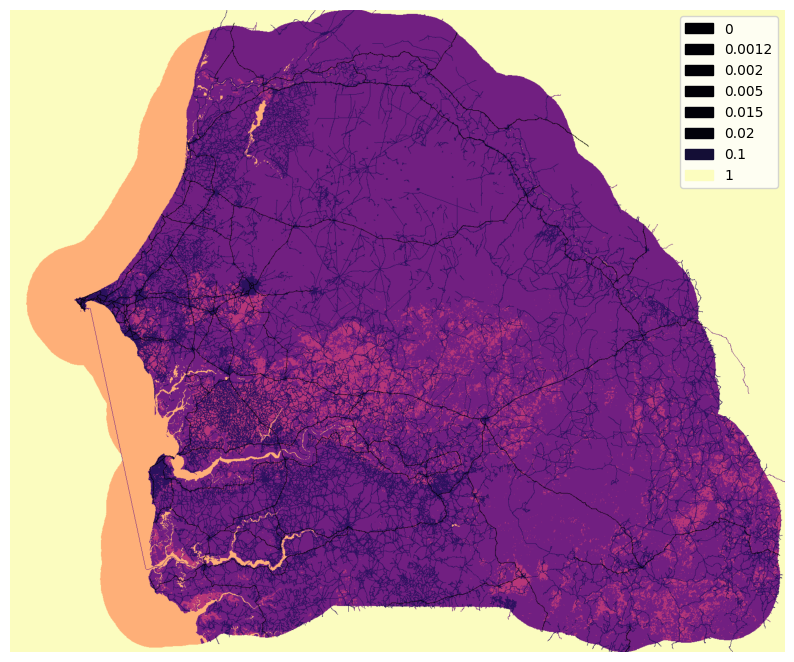

In [10]:
mapMisc.static_map_raster(rasterio.open(local_friction), thresh=[0,0.0012, 0.002, 0.005, 0.015, 0.02, 0.1, 1])

<module 'matplotlib.pyplot' from 'c:\\WBG\\Anaconda3\\envs\\s2s_ingest\\lib\\site-packages\\matplotlib\\pyplot.py'>

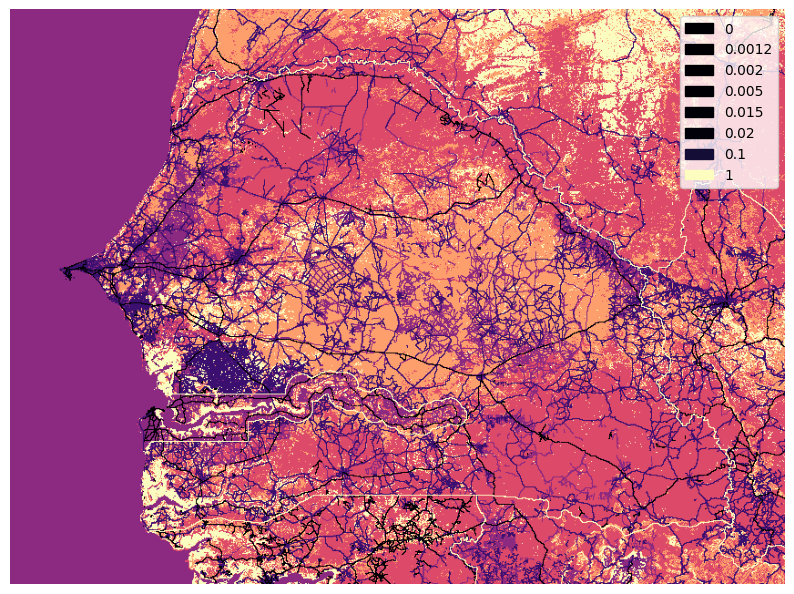

In [11]:
# map the global friction surface for comparison
mapMisc.static_map_raster(rasterio.open(friction_surface_file), thresh=[0,0.0012, 0.002, 0.005, 0.015, 0.02, 0.1, 1])
